# EYE FOR BLIND
* This notebook will be used to prepare the capstone project 'Eye for Blind'
* Our primary objective is to generate caption for a provided image. We will use CNN-RNN based Attention model to achive this goal. 
* We have used flicker8k images along with around 5 different types of captions. 
* CNN will create a feature map evaluating traing images aganist provided caption and with help of RNN (gru here) we generate the captions. 
* We We have used gredy search approch to generate the caption and evaluated the result using BELU score. 
* There are more indepth work involved here as part of saving featuremap to reuse, Attention model with Teacher forcing to achive better results, etc.

#### - Here we have 2 parts,
              1. create the feature map and 
              2. Use it in Attention model.
 So, if we are running this file first time, we need to keep **'Create_image_features = True'** to save the mapping file on storage. Later we will mark it False, not to generate the map again and reuse the mapping file generated in first run.
* Also, we are running it on Goggle colab and we should make sure to have 10GB of available space torun it sucessfully. In 3rd cell, please update the path of the storage which will contain 'Image' folder for traning images and other files outside of image folder. IITB_Capstone > Data > Images    


In [ ]:
#Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

import os
import sys
import shutil

import warnings
warnings.filterwarnings('ignore')

import glob
from collections import Counter
import string

import nltk
from nltk.corpus import stopwords
import keras
import tensorflow as tf

import pickle
from sklearn.model_selection import train_test_split
import time
from PIL import Image

from tqdm import tqdm

##### if running first time and want to create image features and save, make the marker as True 

In [ ]:
### if running first time and want to create image features and save, make the marker as True else, 
### once the features ready and want to improve the model or execute the model, we can keep the marker False.

# Create_image_features = True
Create_image_features = False

## Setup storage path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ROOT_FOLDER = "/content/gdrive/MyDrive/IITB_Capstone/"

Mounted at /content/gdrive


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
#Import the dataset and read the image into a seperate variable

images_folder_path =  ROOT_FOLDER + 'Data/Images'

all_imgs = glob.glob(images_folder_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [ ]:
## Import caption file into a dataFrame

captions_file_path = ROOT_FOLDER + 'Data/captions.txt'
captions_df = pd.read_csv(captions_file_path)
captions_df.head(15)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


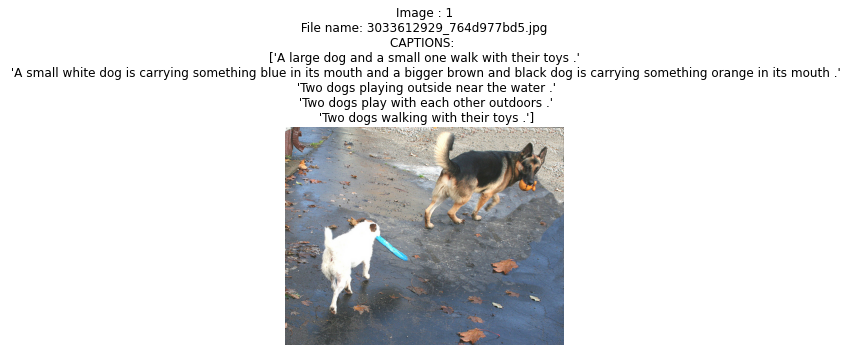

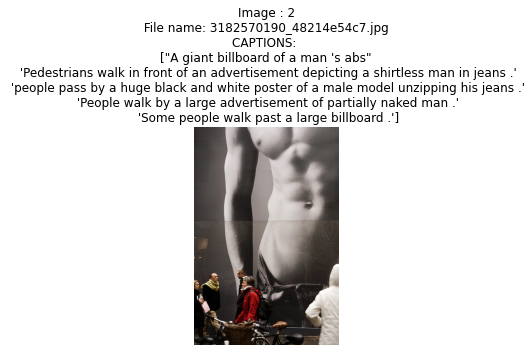

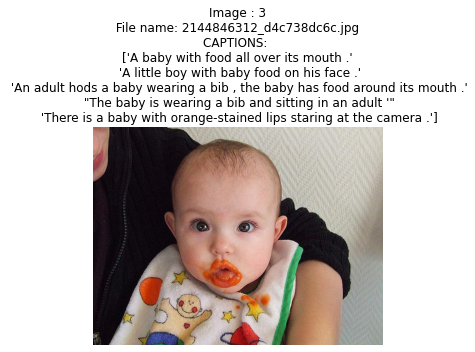

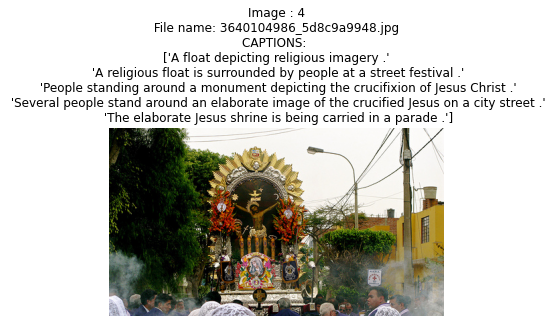

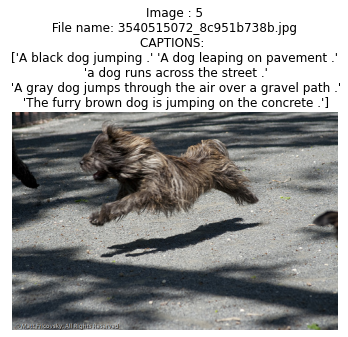

In [ ]:
#Visualise both the images & text present in the dataset

number_of_image = 5
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(number_of_image):
    referance_number = rd.randint(0, len(all_imgs))
    image_path = all_imgs[referance_number]
    image = plt.imread(image_path)
    Image_file_name = image_path.split("/")[-1]
    plt.imshow(image)
    plt.axis('off')

    caption_text = captions_df[captions_df.image == Image_file_name]["caption"].values
    plt.title(f'Image : {i+1}\n File name: {Image_file_name} \nCAPTIONS: \n{caption_text}' )
    plt.show()
    print()


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
# all_img_id= #store all the image id here
# all_img_vector= #store all the image path here
# annotations= #store all the captions here
# df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

pd.set_option('max_colwidth', 500)

df = captions_df.copy()
df.rename(columns = {'image':'ID', 'caption' : 'Captions'}, inplace = True)
df["Path"] = df.ID.apply(lambda x : f'{images_folder_path}/{x}')

## remove newline and . from each captions
# df["Captions"] = df.Captions.apply(lambda x : x.rstrip('\n.'))
df["Captions"] = df.Captions.apply(lambda x : ''.join(l for l in x if l not in string.punctuation))

df = df[['ID','Path', 'Captions']]

df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
5,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg,A black dog and a tricolored dog playing with each other on the road
7,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street
8,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road
9,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other


In [ ]:
#Create the vocabulary & the counter for the captions
annotations=df.Captions.values

vocabulary = [word.lower()     for caption in annotations      for word in caption.split()]

val_count=Counter(vocabulary)
print("Number of words present :", len(val_count))
print()
val_count.most_common(30)

Number of words present : 8828



[('a', 62986),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

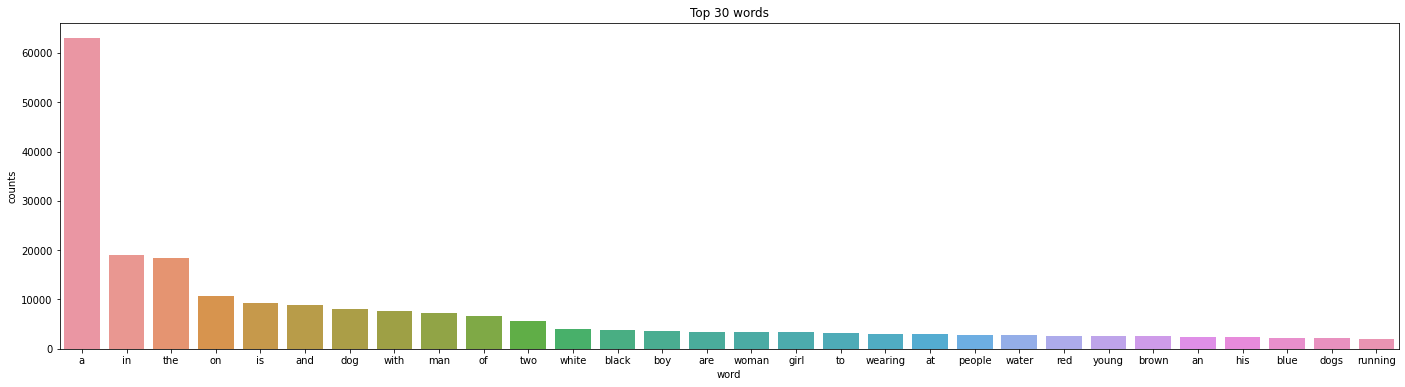

In [ ]:
#Visualise the top 30 occuring words in the captions
top30_list = val_count.most_common(30)
top30_df = pd.DataFrame(top30_list, columns = ["word", "counts"])


fig, ax = plt.subplots(figsize=(24, 6))

sns.barplot(data=top30_df, x = 'word', y='counts')
plt.title("Top 30 words")

plt.show()

-- **We can see most common words are the stopwords. Lets remove them and see the most occuring words**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


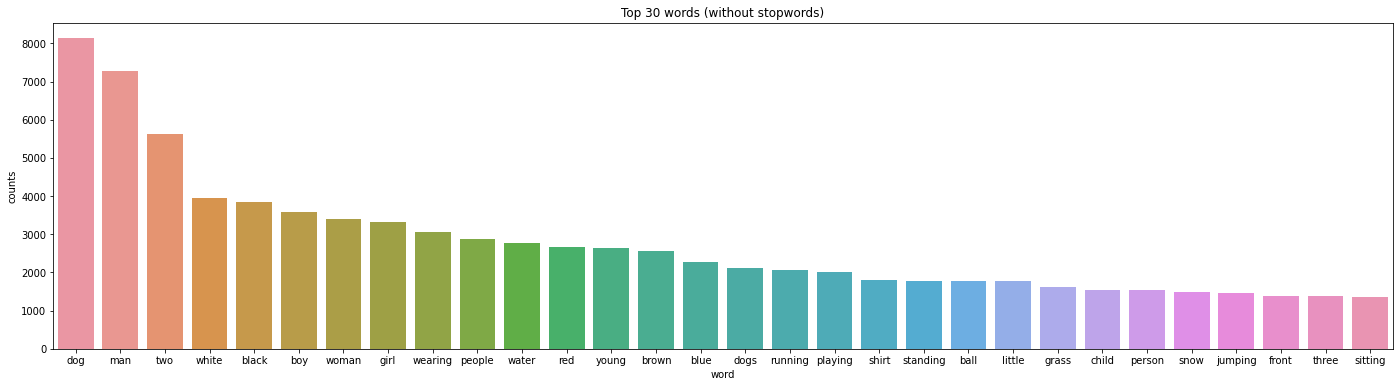

In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

val_count_no_Stop_word = dict()

for word, count in val_count.most_common(100):
    if word not in stop_words:
      val_count_no_Stop_word[word] = count

val_count_no_Stop_word = Counter(val_count_no_Stop_word)
# val_count_no_Stop_word.most_common(30)

#Visualise the top 30 occuring words in the captions
top30_list2 = val_count_no_Stop_word.most_common(30)
top30_df2 = pd.DataFrame(top30_list2, columns = ["word", "counts"])


fig, ax = plt.subplots(figsize=(24, 6))

sns.barplot(data=top30_df2, x = 'word', y='counts')
plt.title("Top 30 words (without stopwords)")

plt.show()

In [ ]:
#Create a list which contains all the captions
annotations=df.Captions.values

#add the <start> & <end> token to all those captions as well
annotations_with_tag = ['<start> ' + caption + ' <end>' for caption in annotations]

#Create a list which contains all the path to the images
all_img_path=df.Path.values

print("Total captions present in the dataset: "+ str(len(annotations_with_tag)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
print("Max length of a caption:", max([len(line) for line in annotations_with_tag]))
print()

## Let see how captions looks like without punctuation, and added annotations
annotations_with_tag[:5]

Max length of a caption: 210



['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer

#your code here
tokenizer = tf.keras.preprocessing.text.Tokenizer(
num_words = 5000,                                    # out of 8000+ words, we will consider 5000
filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ \t\n',          # we have already filtered punctuations, however here we are removing some more charecters like tab etc.
lower = True, 
split = " ", 
char_level = False, 
oov_token = '<unk>')                               # marking the words UNK which are not present in 5000 words.

# fitting the tokenizer
tokenizer.fit_on_texts(annotations_with_tag)

# Converting sentences to sequences of word token indexes
tokenized_word_sequences = tokenizer.texts_to_sequences(annotations_with_tag)
tokenized_word_sequences[:10]


[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4],
 [3, 2, 16, 10, 9, 2, 853, 10, 18, 344, 4],
 [3, 2, 16, 10, 9, 2, 1563, 10, 35, 11, 138, 83, 7, 6, 156, 4],
 [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 998, 18, 638, 23, 138, 83, 5, 6, 73, 4],
 [3, 14, 32, 13, 739, 2650, 89, 23, 138, 83, 7, 6, 156, 4],
 [3, 14, 32, 7, 721, 797, 320, 138, 83, 4]]

In [ ]:
# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index
index_word = tokenizer.index_word
#your code here
word = "<end>" 

print(f"index of word {word} is: {word_index[word]}")
print(f"word for index 4 is: {index_word[4]}")


index of word <end> is: 4
word for index 4 is: <end>


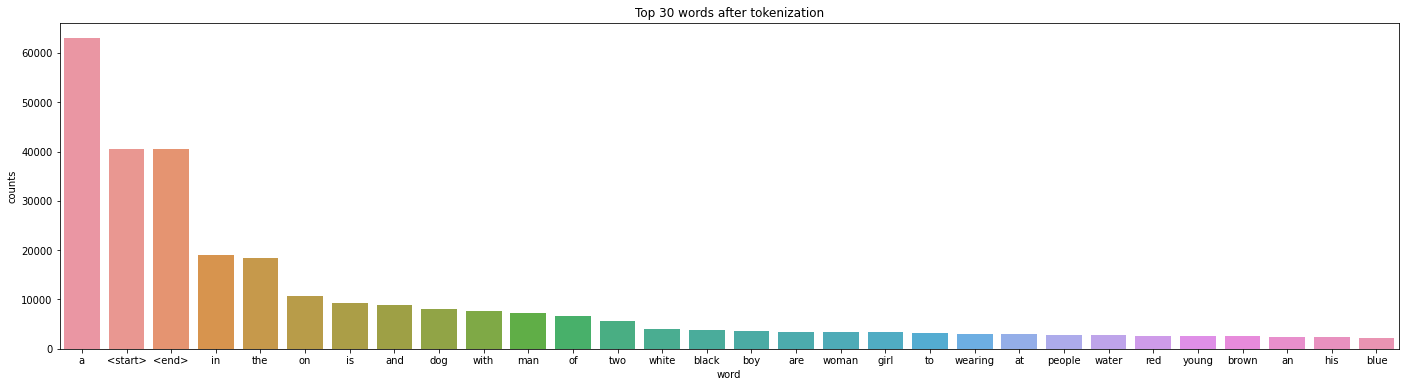

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_counts = Counter(tokenizer.word_counts)

top30_words = word_counts.most_common(30)
top30_words_df2 = pd.DataFrame(top30_words, columns = ["word", "counts"])


fig, ax = plt.subplots(figsize=(24, 6))

sns.barplot(data=top30_words_df2, x = 'word', y='counts')
plt.title("Top 30 words after tokenization")

plt.show()

#your code here

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_word_matrix_len = max([len(word) for word in tokenized_word_sequences])

print("Max length of tokenized word sequence: ", max_word_matrix_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(tokenized_word_sequences, 
                                                          padding='post',
                                                          maxlen=max_word_matrix_len,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

Max length of tokenized word sequence:  38
The shape of Caption vector is :(40455, 38)


In [ ]:
## word tokenized matrix after padding
cap_vector[:2]

array([[  3,   2,  43,   5,   2,  91, 171,   8, 120,  54,   2, 396,  13,
        393,   5,  29,   1, 694,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   2,  20, 315,  65,   2, 195, 118,   4,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [ ]:
# Lets add padding information to tokenizer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

word_index = tokenizer.word_index
index_word = tokenizer.index_word

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
#write your code here to create the dataset consisting of image paths

image_set = tf.data.Dataset.from_tensor_slices(all_img_path)

count = 0
for i in image_set:
  print(i.numpy().decode("utf-8"))
  count += 1
  if count > 5:
    break

/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg
/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg
/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg
/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg
/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg
/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1001773457_577c3a7d70.jpg


In [ ]:
#write your code here for creating the function. This function should return images & their path
IMAGE_SHAPE= (299, 299)
BATCH_SIZE = 128


def load_image(image_path):
    #write your pre-processing steps here
    image = tf.io.read_file(image_path)                                  ## reading image file
    image = tf.image.decode_jpeg(image, channels=0)                      # channels = 0 for image same as imput image channel and for RGB inputs channel = 3 
    image = tf.image.resize(image,IMAGE_SHAPE)                           ## resizing image
    image = tf.keras.applications.inception_v3.preprocess_input(image)    ## Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.
    # print(np.max(image.numpy()))
    # print(image.shape)
    return image, image_path

# load_image('/content/gdrive/MyDrive/IITB_Capstone/Data/Images/1000268201_693b08cb0e.jpg')    

Out of many experiment we could not reduce BATCH_SIZE less than 64, karnel dying out after sometime. if we increase the BATCH_SIZE to 256 or 512 , we get lower train and test error however prediction (BELU score) not coming correct. So we tried with 128 batch size here.

In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

#write your code here
## Unique list of images
unique_image_list = list(set(all_img_path))
## creating tf dataset
image_set = tf.data.Dataset.from_tensor_slices(unique_image_list)

## creating the data pipeline and optimize the cpu usage
image_set = image_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## converting them into batch
image_set = image_set.batch(BATCH_SIZE,drop_remainder=False)

print(image_set)

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
## check the shape of the image batch

sample_batch_image, sample_batch_path = next(iter(image_set))
print(sample_batch_image.shape)          #(batch_size, 299,299,3)
print(sample_batch_path.shape)            #(batch_size, max_len)

(128, 299, 299, 3)
(128,)


IMAGE path:  /content/gdrive/MyDrive/IITB_Capstone/Data/Images/3425573919_409d9e15b2.jpg


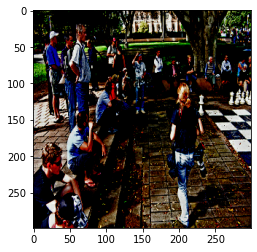

In [ ]:
## print a random image from sample_batch_image to cross check that image and its path is aligned
plt.imshow(sample_batch_image[3])
print("IMAGE path: ", sample_batch_path[3].numpy().decode("utf-8"))
plt.show()

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                                                                   #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output                                                    #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)                          #build the final model using both input & output layer

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# image_features_extract_model.summary()

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
# image_set
# image_features_extract_model

feature_folder = ROOT_FOLDER + "features/"

if Create_image_features == True:

    if os.path.exists(feature_folder):
        shutil.rmtree(feature_folder)
    if not os.path.exists(feature_folder):
        os.mkdir(feature_folder)

    with tf.device('/device:GPU:0'):

        for image, image_path in tqdm(image_set):
          features_batch = image_features_extract_model(image)                ##output -> [64, 8, 8, 2048]
          # print(features_batch.get_shape().as_list())
          # break
          features_batch_reshaped = tf.reshape(features_batch,                   ## reshape from 4D to 3D  :  [64, 8, 8, 2048] -> [64, 64, 2048]
                                          (features_batch.shape[0],              #batch size = 64
                                              -1,                               # help to become 8,8 to 64 
                                          features_batch.shape[3]))             # keeping 2048 fixed

          for image_batch, image_path in zip(features_batch_reshaped, image_path):
            image_name = image_path.numpy().decode("utf-8").split('/')[-1]
            features = image_batch.numpy()
            features = tf.reshape(features, (-1, tf.shape(features)[-1]))

            # Caching Image Features 
            feature_path =  feature_folder + image_name.split('.')[0] + '_features_.npy'
            np.save(feature_path, features)
    


Initially tried with creating dictionary and update as key (image path) and value (feature map) format. the final size of this dictionary end up to 4 GB and system was crashing to keep this dictionary in memeory. So tried with alternative approch as sugessted here. saved each feature as np.save in npy format. 

In [ ]:
### check number of feature files saved same as number of images
if Create_image_features == True:

    image_fileName = list(df["ID"].unique())
    print("Total images: ", len(image_fileName))

    count = 0
    for image_name in image_fileName:
      feature_path =  feature_folder + image_name.split('.')[0] + '_features_.npy'
      if os.path.isfile(feature_path):
        count += 1
      else:
        print(f'{image_name} not found')

    print("total matched feature files: ", count)


## Dataset creation ----------------------------------------------------------------------------------------------------------------------
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(df.Path, cap_vector, test_size=0.2, random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_with_path, caption):
  # img_tensor = image_features_directory[image_with_path.decode('utf-8')]
  #  print(image_with_path)

   if isinstance(image_with_path, str):
     image_name = image_with_path.split('/')[-1]
   else:
     image_name = image_with_path.decode("utf-8").split('/')[-1]
       
   feature_path =  feature_folder + image_name.split('.')[0] + '_features_.npy'
   features = np.load(feature_path)
  #  img_tensor = tf.reshape(features, (-1, tf.shape(features)[-1]))
   img_tensor = features


   return img_tensor, caption

In [ ]:
### check if the map_func is working and shape of image feature

feature, caption = map_func(all_img_path[0], "CAPTION 1")
print(caption)
print("SHAPE of image feature: ", feature.shape)

CAPTION 1
SHAPE of image feature:  (64, 2048)


### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BUFFER_SIZE = 1024

def gen_dataset(image_path_set, caption_set):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((image_path_set, caption_set))
    dataset = dataset.shuffle(BUFFER_SIZE, seed=42, reshuffle_each_iteration=True)
    dataset = dataset.map(lambda path, caption: tf.numpy_function(map_func, [path, caption], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)
    
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset



In [ ]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(128, 64, 2048)
(128, 38)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001                                                      #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE                        #len(total train images) // BATCH_SIZE 
test_num_steps =  len(path_test)  // BATCH_SIZE                        #len(total test images) // BATCH_SIZE


max_length = sample_cap_batch.shape[1]                   ## 38 
attention_features_shape = feature.shape[0]     ## 64

### Encoder

In [ ]:
## we have added a Dropout layer for this experiment to find effect in different predictions
    # with tf.device('/device:GPU:0'):

    Model = tf.keras.Model

    class Encoder(Model):
        def __init__(self,embed_dim):
            super(Encoder, self).__init__()
            self.dense =  tf.keras.layers.Dense(embed_dim, activation='relu')                                #build your Dense layer with relu activation
            self.dropout = tf.keras.layers.Dropout(0.25)                                                                                #build your Dropout layer

            
        def call(self, features):
            features =  self.dense(features)                                                                 # extract the features from the image shape: (batch, 8*8, embed_dim)
            features =  self.dropout(features)

            return features

In [ ]:
# create the encoder object.
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
    # with tf.device('/device:GPU:0'):

    class Attention_model(Model):
        def __init__(self, units):
            super(Attention_model, self).__init__()
            self.units = units
            self.W1 = tf.keras.layers.Dense(units)        #build your Dense layer
            self.W2 = tf.keras.layers.Dense(units)        #build your Dense layer
            self.V = tf.keras.layers.Dense(1)             #build your final Dense layer with unit 1

        def call(self, features, hidden):
            #features shape: (batch_size, 8*8, embedding_dim)
            # hidden shape: (batch_size, hidden_size)
            hidden_with_time_axis =  tf.expand_dims(hidden, 1)                                                   # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
            score = tf.keras.activations.tanh(   self.W1(features) + self.W2(hidden_with_time_axis)   )          # build your score funciton to shape: (batch_size, 8*8, units)
            attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)                             # extract your attention weights with shape: (batch_size, 8*8, 1)
            context_vector =  attention_weights * features                                                       #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
            context_vector = tf.reduce_sum(context_vector, axis=1)                                               # reduce the shape to (batch_size, embedding_dim). it reduce the dimension as er axis number
            

            return context_vector, attention_weights


### Decoder

* output from encoder along with hidden state is passed to attention model.
* The attention model generates context vector. we concatenated this context vector with embedded vector formed from embedding layer (for text part) and pass to GRU. We tthen pass the output of GRU layer to a dense layer and then convert the shape of output same as vocab_size. Intention behind this conversion is to calculate the probabilities for each word in the vocabulary.

In [ ]:
   ## we have added a Dropout layer with different size. here we have dded 40% for this experiment to find effect in different predictions

    # with tf.device('/device:GPU:0'):

    class Decoder(Model):
        def __init__(self, embed_dim, units, vocab_size):
            super(Decoder, self).__init__()
            self.units=units
            self.attention = Attention_model(units)                                                                                     #iniitalise your Attention model with units
            self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)                                                                    #build your Embedding layer
            self.gru = tf.keras.layers.GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
            self.d1 = tf.keras.layers.Dense(units)                                                                                      #build your Dense layer
            self.d2 = tf.keras.layers.Dense(vocab_size)      
            # self.dropout = tf.keras.layers.Dropout(0.25)                                                                                #build your Dropout layer
            self.dropout = tf.keras.layers.Dropout(0.4)                                                                                #build your Dropout layer
            

        def call(self,x,features, hidden):
            context_vector, attention_weights = self.attention(features, hidden)                                          #create your context vector & attention weights from attention model
            # tf.print("context_vector: \n", context_vector)
            # tf.print("attention_weights: \n", attention_weights)
            
            embed = self.dropout(self.embed(x))
            # embed = self.embed(x)                                                                                         # embed your input to shape: (batch_size, 1, embedding_dim)
            embed =  tf.concat([tf.expand_dims(context_vector,1), embed], axis=-1)                                        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
            output, state = self.gru(embed)                                                                                # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
            output = self.d1(output)
            output = tf.reshape(output, (-1, output.shape[2]))                                                            # shape : (batch_size * max_length, hidden_size)
            output = self.d2(output)                                                                                      # shape : (batch_size * max_length, vocab_size)
            
            return output, state, attention_weights
        
        def init_state(self, batch_size):
            return tf.zeros((batch_size, self.units))


In [ ]:
# create the dicoder object. and nested attention model

decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
### output of the encoder is image feature vector
features=encoder(sample_img_batch)

### initialize with zero vector with same size of batch size and units.
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)

print('Feature shape from Encoder: {}'.format(features.shape))                                               #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape))                                        #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))                            #(batch, 8*8, embed_dim)

Feature shape from Encoder: (128, 64, 256)
Predcitions shape from Decoder: (128, 5001)
Attention weights shape from Decoder: (128, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()                                                                                       #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)       #define your loss object. SparseCategoricalCrossentropy helps to calculate loss between labels and predicton.

In [ ]:
## due to padding there are 0's added. So we need to mask the 0 as FALSE so that decoder do not give importance to the value.

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)                             # average loss across batch

In [ ]:
checkpoint_path = ROOT_FOLDER + "checkpoint/"
# shutil.rmtree(checkpoint_path)
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)


checkpoint_path = checkpoint_path
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
# tf.compat.v1.enable_eager_execution()

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):

          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)                        ## 
          loss = loss + loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
          
    #backpropagation
    avg_loss = (loss / int(target.shape[1])) 
    trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradiants = tape.gradient(loss, trainables_variables)                                             # it calculates the gradients with respect to every trainable variable

    optimizer.apply_gradients(zip(gradiants, trainables_variables))                                   # compute gradients and apply it to the optimizer and backpropagate.

        

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        
    encoder_output = encoder(img_tensor)
        
    for i in range(1, target.shape[1]):

          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)                        ## 
          loss = loss + loss_function(target[:, i], predictions)
          
          predicted_value = tf.argmax(predictions[0])                                                ## here we are using the prediction with heighest value and passing to next step as input for next round
          dec_input = tf.expand_dims([predicted_value] * target.shape[0] , 1)



    avg_loss = (loss / int(target.shape[1])) 

    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    total_avg_loss = 0
    
    #write your code to get the average loss result on your test data
    for img_tensor, target in test_dataset:
        loss, avg_loss = test_step(img_tensor, target)
        total_avg_loss = total_avg_loss + avg_loss

    avg_test_loss  =  (total_avg_loss / int(target.shape[1]))         

    return avg_test_loss

In [ ]:
    # with tf.device('/device:GPU:0'):

    loss_plot = []
    test_loss_plot = []
    EPOCHS = 15

    best_test_loss=100

    print("Iterations per epoch: ", train_num_steps)
    start0 = time.time()

    for epoch in range(0, EPOCHS):
        start = time.time()
        total_loss = 0
        print(f"EPOCH: {epoch+1}  out of {EPOCHS} epochs")

        for (batch, (img_tensor, target)) in tqdm(enumerate(train_dataset)):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss
            avg_train_loss=total_loss / train_num_steps
            
        loss_plot.append(avg_train_loss)    
        test_loss = test_loss_cal(test_dataset)
        test_loss_plot.append(test_loss)
        
        print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))

        if test_loss < best_test_loss:
            print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
            best_test_loss = test_loss
            ckpt_manager.save()

        print ('Time taken for 1 epoch {} sec'.format(time.time() - start))
        
        minutes, seconds = divmod(time.time() - start0, 60)
        print (f'Time taken till now {minutes} mins {seconds} sec\n')


Iterations per epoch:  252
EPOCH: 1  out of 15 epochs


252it [31:17,  7.45s/it]


For epoch: 1, the train loss is 1.415, & test loss is 3.484
Test loss has been reduced from 100.000 to 3.484
Time taken for 1 epoch 1921.108062505722 sec
Time taken till now 32.0 mins 1.1083674430847168 sec

EPOCH: 2  out of 15 epochs


252it [01:57,  2.14it/s]


For epoch: 2, the train loss is 1.079, & test loss is 3.267
Test loss has been reduced from 3.484 to 3.267
Time taken for 1 epoch 146.71748208999634 sec
Time taken till now 34.0 mins 27.82602024078369 sec

EPOCH: 3  out of 15 epochs


252it [05:01,  1.20s/it]


For epoch: 3, the train loss is 0.972, & test loss is 3.301
Time taken for 1 epoch 336.3531928062439 sec
Time taken till now 40.0 mins 4.17940354347229 sec

EPOCH: 4  out of 15 epochs


252it [02:03,  2.04it/s]


For epoch: 4, the train loss is 0.904, & test loss is 3.294
Time taken for 1 epoch 152.3451542854309 sec
Time taken till now 42.0 mins 36.52469301223755 sec

EPOCH: 5  out of 15 epochs


252it [01:59,  2.11it/s]


For epoch: 5, the train loss is 0.852, & test loss is 3.358
Time taken for 1 epoch 148.9105727672577 sec
Time taken till now 45.0 mins 5.435875654220581 sec

EPOCH: 6  out of 15 epochs


252it [02:01,  2.08it/s]


For epoch: 6, the train loss is 0.806, & test loss is 3.283
Time taken for 1 epoch 150.13702845573425 sec
Time taken till now 47.0 mins 35.57394361495972 sec

EPOCH: 7  out of 15 epochs


252it [02:02,  2.05it/s]


For epoch: 7, the train loss is 0.767, & test loss is 3.429
Time taken for 1 epoch 151.62733554840088 sec
Time taken till now 50.0 mins 7.201402187347412 sec

EPOCH: 8  out of 15 epochs


252it [01:58,  2.13it/s]


For epoch: 8, the train loss is 0.730, & test loss is 3.425
Time taken for 1 epoch 147.40887570381165 sec
Time taken till now 52.0 mins 34.610769510269165 sec

EPOCH: 9  out of 15 epochs


252it [01:59,  2.11it/s]


For epoch: 9, the train loss is 0.695, & test loss is 3.470
Time taken for 1 epoch 149.91374683380127 sec
Time taken till now 55.0 mins 4.525108575820923 sec

EPOCH: 10  out of 15 epochs


252it [02:00,  2.09it/s]


For epoch: 10, the train loss is 0.663, & test loss is 3.590
Time taken for 1 epoch 149.66342878341675 sec
Time taken till now 57.0 mins 34.189196825027466 sec

EPOCH: 11  out of 15 epochs


252it [01:58,  2.13it/s]


For epoch: 11, the train loss is 0.634, & test loss is 3.641
Time taken for 1 epoch 147.38844275474548 sec
Time taken till now 60.0 mins 1.5778000354766846 sec

EPOCH: 12  out of 15 epochs


252it [01:59,  2.11it/s]


For epoch: 12, the train loss is 0.604, & test loss is 3.705
Time taken for 1 epoch 148.29057478904724 sec
Time taken till now 62.0 mins 29.869089603424072 sec

EPOCH: 13  out of 15 epochs


252it [02:00,  2.09it/s]


For epoch: 13, the train loss is 0.578, & test loss is 3.711
Time taken for 1 epoch 150.59860634803772 sec
Time taken till now 65.0 mins 0.4683253765106201 sec

EPOCH: 14  out of 15 epochs


252it [02:00,  2.09it/s]


For epoch: 14, the train loss is 0.551, & test loss is 3.892
Time taken for 1 epoch 149.53064513206482 sec
Time taken till now 67.0 mins 29.99910068511963 sec

EPOCH: 15  out of 15 epochs


252it [01:59,  2.10it/s]


For epoch: 15, the train loss is 0.528, & test loss is 3.971
Time taken for 1 epoch 149.13031649589539 sec
Time taken till now 69.0 mins 59.13078188896179 sec



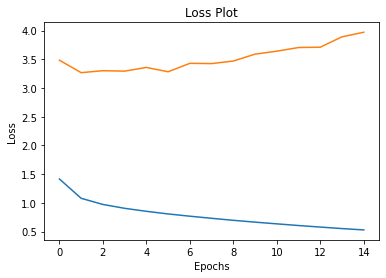

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)                                                        # process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)                                                   # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features_encoder_output = encoder(img_tensor_val)                                                                          # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights =  decoder(dec_input, features_encoder_output, hidden)                           # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()                                                                        # extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])                                                               #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
   
   
    return result, attention_plot,predictions


In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def image_Caption_generator(test_image, test_caption, belu_weights = (0.5, 0.5, 0, 0)):

      # rid = np.random.andint(0, len(img_test))
      # test_image = img_test[rid]
      #test_image = './images/413231421_43833a11f5.jpg'
      #real_caption = '<start> black dog is digging in the snow <end>'
      # real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])

      real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption if i not in [0]])
      result, attention_plot, pred_test = evaluate(test_image)

      real_caption=filt_text(real_caption)      

      pred_caption=' '.join(result).rsplit(' ', 1)[0]

      real_appn = []
      real_appn.append(real_caption.split())
      reference = real_appn
      candidate = pred_caption.split()

      score = sentence_bleu(reference, candidate, weights= belu_weights)                     #set your weights
      print(f"BELU score: {score*100}")

      print ('Real Caption:', real_caption)
      # print("Real Caption:")
      # print(captions_df[captions_df.image ==test_image.split('/')[-1]]["caption"].values)
      print ('\nPrediction Caption:', pred_caption)
      plot_attmap(result, attention_plot, test_image)

      return pred_caption 



image number: 1961
BELU score: 35.01806396568502
Real Caption: a man riding a bucking bull at a rodeo

Prediction Caption: a man is riding a bull


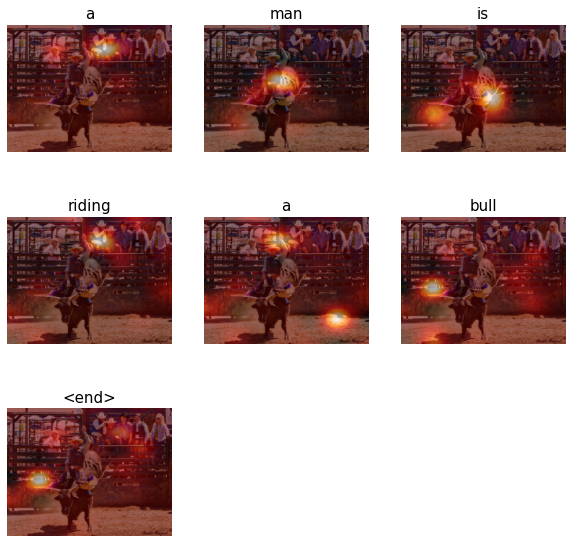

-----------------------------------------------------------------------------



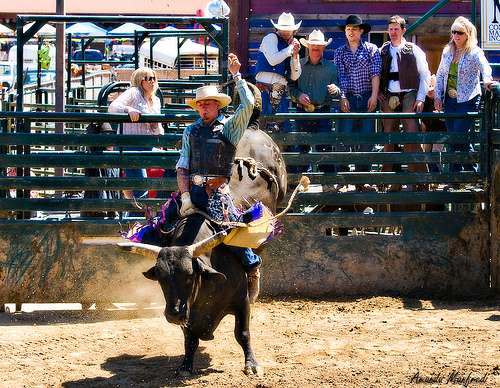

In [ ]:
rid = np.random.randint(0, len(path_test))                                          ## random image number for test images
print("image number:", rid)
test_image = path_test.values[rid]                                                        ## test image output from train_test_split
test_caption = cap_test[rid]                                                       ## test caption extracted from train_test_split


pred_caption = image_Caption_generator(test_image,test_caption)

# path_test, cap_train, cap_test

print("-----------------------------------------------------------------------------\n")

Image.open(test_image)


image number: 148
BELU score: 62.36095644623235
Real Caption: a woman with a pink boa walks down a sidewalk

Prediction Caption: a woman in a pink boa walks down the street


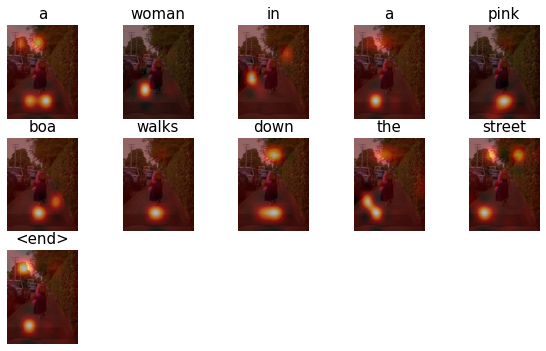

-----------------------------------------------------------------------------



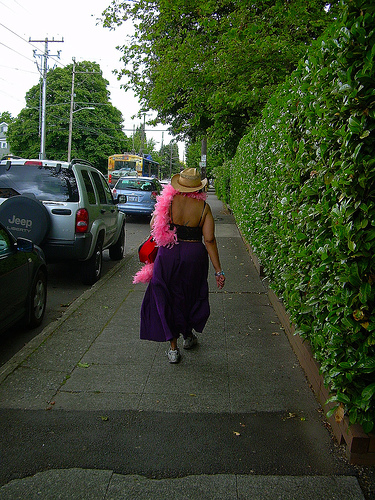

In [ ]:
rid = np.random.randint(0, len(path_test))                                          ## random image number for test images
print("image number:", rid)
test_image = path_test.values[rid]                                                        ## test image output from train_test_split
test_caption = cap_test[rid]                                                       ## test caption extracted from train_test_split


pred_caption = image_Caption_generator(test_image,test_caption)

# path_test, cap_train, cap_test

print("-----------------------------------------------------------------------------\n")

Image.open(test_image)

### Script to create voice file using the text generated that will be saved as mp3 format

In [ ]:
# !pip install gtts

In [ ]:
# # Import the required module for text to speech conversion
# from gtts import gTTS

# # Language in which you want to convert
# language = 'en'
  
# # Passing the text and language to the engine, 
# myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# # Saving the converted audio in a mp3 file named
# myobj.save(ROOT_FOLDER + "Predicted_text.mp3")
  
# # Playing the converted file
# os.system( ROOT_FOLDER +"Predicted_text.mp3")